In [654]:
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import scipy
import time

sys.path.append('./src')
from generative_graph_models import initialize_sparse_L, normalize_sparse_L, define_graph_instance
from algorithms_optimal import cvx_optimizer
from utils import set_mkl_threads, assert_results
from generative_opinions_models import define_set_opinions, standardize, normalize

set_mkl_threads(16)

code = "8f3f169e2449ad86a8f49b03ec7f155a"
basepath = f"./datasets/experiments/runtime_task__degree_constraint/{code}"
#with open(f"{basepath}/experiments_data_method.pkl", "rb") as file:
#    exps = pickle.load(file)
G_true = nx.read_gexf(f"{basepath}/graph_sample00_python.gexf", node_type=int)
s = np.load(Path(basepath) / Path("internal_opinions_sample00_python.npy"))
b = np.load(Path(basepath) / Path("budgets_sample00_python.npy"))
L_eq = scipy.sparse.load_npz(Path(basepath) / Path("L_eq_sparse_sample00_python.npz"))
z_eq = np.load(Path(basepath) / Path("eq_opinions_sample00_python.npy"))
n = len(s)
print(b, s.shape)
print(L_eq.diagonal().max())

8108 (50000, 1)
1.0


In [768]:
(D - A)/max(A.sum(axis=1))

matrix([[ 0.5, -0.5,  0. ,  0. ],
        [-0.5,  1. , -0.5,  0. ],
        [ 0. , -0.5,  1. , -0.5],
        [ 0. ,  0. , -0.5,  0.5]])

In [791]:
scipy.multiply(R, R.sum(axis=1))

/tmp/ipykernel_3122965/542659838.py:1: DeprecationWarning: scipy.multiply is deprecated and will be removed in SciPy 2.0.0, use numpy.multiply instead
  scipy.multiply(R, R.sum(axis=1))


matrix([[2, 2, 0, 0],
        [4, 8, 4, 0],
        [0, 4, 8, 4],
        [0, 0, 2, 2]])

In [792]:
A_ = scipy.sparse.csr_matrix(A)
D_ = scipy.sparse.csr_matrix(D)
R = (D_ + A_)
for _ in range(10):
    
    R = R.multiply(R.sum(axis=1))
    R = R.multiply(R.sum(axis=0))
    if np.all(R.sum(axis=1).flatten()-np.ones(R.shape[0]) < 1e-6):
        print(f"Iteration {_}")
        break

Iteration 3


True

In [762]:
max(A.sum(axis=1))

matrix([[2]])

In [ ]:

define_graph_instance(net_model, {'n': numb_nodes, e_param_name: e_param_value})

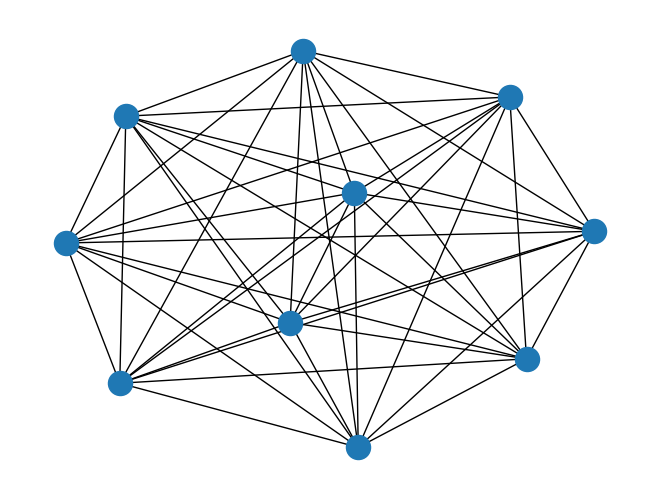

In [735]:
n = 10
β = 5.
α = 5.
sizes = [int(n*.55), n-int(n*.55)]
probs = np.array([[np.min([α*(n/2)/(scipy.special.binom(n/2, 2)), 1]), β/(n/2)],
                 [β/(n/2), np.min([α*(n/2)/(scipy.special.binom(n/2, 2)), 1])]])
G = nx.stochastic_block_model(sizes, probs)
nx.draw(G)

In [711]:
IpL = np.identity(n) + L_eq.todense()
z = scipy.linalg.solve(IpL, s, assume_a='pos')
obj = np.dot(s.T, z.reshape(len(z), 1)).item()

ValueError: operands could not be broadcast together with shapes (10,10) (50000,50000) 

In [602]:
n = 10
np.array([[np.min([5*(n/2)/(scipy.special.binom(n/2, 2)), 1]), 0.5/(n/2)],
                      [0.5/(n/2), np.min([5*(n/2)/(scipy.special.binom(n/2, 2)), 1])]])

array([[1. , 0.1],
       [0.1, 1. ]])

Calculating best minimal value for power law fit
2.8674465043146675
4.0


Text(0.5, 1.05, 'Quakers')

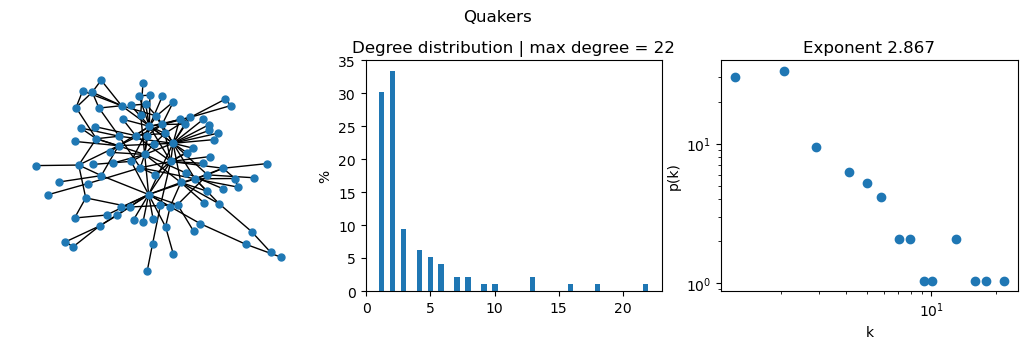

In [603]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3))
nx.draw(G_true, ax=axs[0], node_size=25)
degrees = dict(G_true.degree).values()
counts, values, _ = axs[1].hist(degrees, bins=50, weights=100*np.ones(len(degrees)) / len(degrees))
axs[1].set_title(f"Degree distribution | max degree = {max(degrees)}")
axs[1].set_ylabel("%")

import powerlaw

results = powerlaw.Fit(np.array(list(degrees)))
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')

x = [(values[i]+values[i+1])/2 for i in range(len(values)-1)]
axs[2].scatter(x, counts)
axs[2].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_ylabel("p(k)")
axs[2].set_xlabel("k")
axs[2].set_title(f"Exponent {results.power_law.alpha:.3f}")

plt.suptitle(code2title[code], y=1.05)

### Doubly stochastic --> I generate self-loops

---

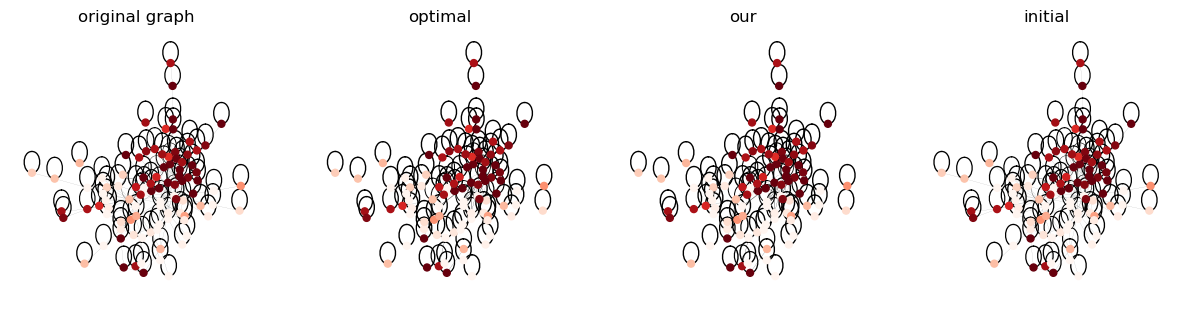

In [604]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3.5))
pos = nx.spring_layout(G_true)
n = G_true.number_of_nodes()


A_eq = np.identity(n) - L_eq.todense()
G_true_scaled = nx.from_numpy_matrix(A_eq)

A_heur = 2*np.identity(n) - exps[0]["IpL"]
G_new = nx.from_numpy_matrix(A_heur)

A_opt = 2*np.identity(n) - exps[1]["IpL"]
G_opt = nx.from_numpy_matrix(A_opt)

L_initial = initialize_sparse_L(L_eq)
A_init = np.identity(n) - L_initial
G_init = nx.from_numpy_matrix(A_init)

for i, (graph, title) in enumerate(zip([G_true_scaled, G_opt, G_new, G_init], 
                                       ["original graph", "optimal", "our", "initial"])):
    weights = [1*graph[u][v]['weight'] for u,v in graph.edges()]
    nx.draw(graph,  pos=pos, node_color=s.T.flatten(), cmap=plt.cm.Reds, 
            vmin=-1, vmax=1, node_size=25, width=weights, ax=axs[i], with_labels = False)
    axs[i].set_title(title)

In [392]:
exps[0]["IpL"].shape

(100, 100)

## Optimization

In [756]:
OPT = 282.23845709397517

In [757]:
L_sparse = initialize_sparse_L(L_eq)


# 1. Initialize variables: Laplacian L, I, from A_init
n = len(s)
I = scipy.sparse.identity(n)
Is, Js = np.nonzero(L_sparse)
L_sparse_prev = L_sparse.copy()
e = L_sparse.count_nonzero()

η = .02#1 / np.linalg.norm(s)**2#1e-2*(n / np.linalg.norm(s))**2 # 1 / np.linalg.norm(s)**2#
η_t = η
cum_μ2 = 0.
q = np.quantile(L_sparse.diagonal(), .99)#np.mean(L_sparse.diagonal())

#### Diameter proxy
L_second = L_sparse.copy()
#η_t = n*1e-3 #b*np.sqrt(2) /np.sqrt(( b*np.sqrt(2) /(q*η))**2 + cum_μ2)
z, _ = scipy.sparse.linalg.bicg(I+L_sparse, s, tol=1e-3)
z = z.reshape((len(s), 1))
grad = np.multiply(z[Is], z[Js]).flatten()
L_second.data += np.multiply(η_t, grad)
L_second[L_second>0.] = 0.
L_second.setdiag(-L_second.sum(axis=1))
L_second = np.multiply(float(1/L_second.diagonal().max()), L_second)
R = scipy.sparse.linalg.norm(L_sparse - L_second)
print(R)

10.673358596619519


In [758]:
L_sparse.shape

(50000, 50000)

In [347]:
######
max_iters = 100
T = max_iters//10
early_stopping = True

routine = "AdaGrad" #AdaGrad Simple_GD


z, _ = scipy.sparse.linalg.bicg(I+L_sparse, s, tol=1e-3)
obj = np.dot(s.T, z.reshape(len(z), 1)).item()
feasible_objectives = [obj]
L_increment = np.inf

η = .02#1/ np.linalg.norm(s)**2 #1e-3*(n / np.linalg.norm(s))**2 # 1/ np.linalg.norm(s)**2#
η_t = η

best_L, best_obj, t_best = (L_sparse.copy(), obj, 1)

time0 = time.time()
# 2. Optimization loop
for t in range(1, int(max_iters)+1):
    # 2.1 grad
    z, _ = scipy.sparse.linalg.bicg(I+L_sparse, s, tol=1e-6)
    z = z.reshape((len(s), 1))
    grad = np.multiply(z[Is], z[Js]).flatten()
    # 2.2 obj
    obj = np.dot(s.T, z.reshape(len(z), 1)).item()
    feasible_objectives.append(obj)
    if obj < best_obj:
        best_L, best_obj, t_best = (L_sparse.copy(), obj, t)
    # 2.3 lr                                  
    norm = scipy.sparse.linalg.norm(L_sparse-L_sparse_prev)
    cum_μ2 = cum_μ2+np.multiply(1/η_t**2, norm**2) if routine == "AdaGrad" else η
    η_t = R/np.sqrt((R/η)**2 + cum_μ2) # 0.01
    if t > 5:
        Δ_obj = (np.min(feasible_objectives[-4:-3]) - np.min(feasible_objectives[-2:-1]))
    if t % T == 0 or t ==0:
        print(f"t={t},  η_t={η_t:.4f}, R/η={(R/η)**2:.3f}, R={R:.3f}, η={η:.3f}, cum_μ2={cum_μ2:.3f}, obj={obj/OPT:.3f}")
        print(f"t={t}, Δ_obj={Δ_obj:.5f}")
    #if t > 5 and t % T == 0 or t ==0:
    #    print(np.min(feasible_objectives[-4:-3]) - np.min(feasible_objectives[-2:-1]))
    #    print(feasible_objectives[1]-np.min(feasible_objectives[1:50]))
        
    # grad step
    #print(L_sparse.todense()[0, :])
    L_sparse_prev = L_sparse.copy()
    
    #print(L_sparse.data)
    print(np.count_nonzero((-L_sparse.sum(axis=1))))
    L_sparse.data += np.multiply(η_t, grad)
    #print(L_sparse.data)
    print(np.count_nonzero((-L_sparse.sum(axis=1))))
    #print(L_sparse.data)
    
        # proj
    L_sparse[L_sparse>0.] = 0.
    for i, _ in enumerate(L_sparse.data):
        print(_)
    L_sparse.setdiag(-L_sparse.sum(axis=1))
    for i, _ in enumerate(L_sparse.data):
        print(_)
    #print(-L_sparse.sum(axis=1))
    I, J, data = scipy.sparse.find(L_sparse)
    assert len(L_sparse.data) == len(Is), (len(L_sparse.data), len(Is), len(I))
    L_sparse = np.multiply(float(1/L_sparse.diagonal().max()), L_sparse)

    # 5.1 Early stopping
    L_increment = scipy.sparse.linalg.norm(L_sparse_prev-L_sparse)
 
    if (time.time()-time0)/(60*60)>=2.:
        print(f"Time limit: stopping at t={t}, L increment", L_increment)
        break
    if t > 10 and early_stopping:
        Δ_obj = (np.min(feasible_objectives[-4:-3]) - np.min(feasible_objectives[-2:-1]))
        if (np.sign(Δ_obj) == 1.) and Δ_obj < 1e-3:
            print(f"Convergence: stopping at t={t},  Δ_obj={Δ_obj:.5f}, η={η:.5f}, obj={obj}")
            break 
        elif (np.sign(Δ_obj) == -1.) and Δ_obj > 5:
            print(f"Convergence: stopping at t={t},  Δup={Δ_obj:.5f}")
            break

278
299
0.0
-0.062148714919767284
-0.05584083991283675
-0.05613039763164538
-0.06236353661892456
-0.05684660658745204
-0.06110228780089379
-0.06211117713073155
-0.05633958214875824
-0.05615175526869217
-0.06208364892839928
0.0
-0.06969149235426089
-0.0693402698877564
-0.048246986043794564
-0.05068499053598789
-0.047163669544336886
-0.06843229152727257
-0.06822221016982392
0.0
-0.045558141037180075
-0.07090050306079336
-0.045492097857990396
-0.062002530585233265
-0.050443992291329676
-0.043317169886077166
-0.07171528614034299
-0.04940445363459863
-0.04451813536506132
-0.04509805834753977
-0.0702442751004628
0.0
-0.04761567117009678
-0.06125908732347496
-0.06760010401445277
-0.0649789345349282
-0.046943497111114334
-0.06690181837114292
-0.06761143906160323
-0.06787821421494764
-0.04786360402974102
-0.04943540807928386
-0.06759120667028803
-0.05251996491816753
0.0
-0.05046840359287903
-0.06705302516831538
-0.06745964752657958
-0.05204463953559815
-0.06535595686343737
-0.0677162219190523
-

AssertionError: (2778, 2777, 2777)

In [796]:
A_sparse.data += grad

ValueError: operands could not be broadcast together with shapes (581146,) (581148,) (581146,) 

In [793]:
A_sparse = L_sparse - scipy.sparse.identity(L_sparse.shape[0])

In [794]:
R = A_sparse.copy()
for _ in range(10):
    
    R = R.multiply(R.sum(axis=1))
    R = R.multiply(R.sum(axis=0))
    if np.all(R.sum(axis=1).flatten()-np.ones(R.shape[0]) < 1e-6):
        print(f"Iteration {_}")
        break

Iteration 0


In [344]:
for _ in L_sparse.data:
    print(_)

0.5911185469481011
-0.062148714919767284
-0.05584083991283675
-0.05613039763164538
-0.06236353661892456
-0.05684660658745204
-0.06110228780089379
-0.06211117713073155
-0.05633958214875824
-0.05615175526869217
-0.06208364892839928
0.4217819100632331
-0.06969149235426089
-0.0693402698877564
-0.048246986043794564
-0.05068499053598789
-0.047163669544336886
-0.06843229152727257
-0.06822221016982392
0.5986946433066095
-0.045558141037180075
-0.07090050306079336
-0.045492097857990396
-0.062002530585233265
-0.050443992291329676
-0.043317169886077166
-0.07171528614034299
-0.04940445363459863
-0.04451813536506132
-0.04509805834753977
-0.0702442751004628
0.7081989494992413
-0.04761567117009678
-0.06125908732347496
-0.06760010401445277
-0.0649789345349282
-0.046943497111114334
-0.06690181837114292
-0.06761143906160323
-0.06787821421494764
-0.04786360402974102
-0.04943540807928386
-0.06759120667028803
-0.05251996491816753
0.5370902965982023
-0.05046840359287903
-0.06705302516831538
-0.06745964752657

In [307]:
I, J, data = scipy.sparse.find(L_sparse)

In [312]:
for i, (x, y) in enumerate(zip(L_sparse.data[1:], data)):
    if x != y:
        print(x, y, i)

-0.05989568741397132 0.5696892004655624 0
-0.053816486739439846 -0.05989568741397132 1
-0.054095547354554 -0.053816486739439846 2
-0.060102721354400715 -0.054095547354554 3
-0.05478579216163429 -0.060102721354400715 4
-0.05888719557798624 -0.05478579216163429 5
-0.059859510452288385 -0.05888719557798624 6
-0.054297148473177445 -0.059859510452288385 7
-0.0541161307303182 -0.054297148473177445 8
-0.05983298020779193 -0.0541161307303182 9
0.40649138883449293 -0.05983298020779193 10
-0.06716502258900792 0.40649138883449293 11
-0.06682653270882817 -0.06716502258900792 12
-0.04649792676286245 -0.06682653270882817 13
-0.048847548233986765 -0.04649792676286245 14
-0.04545388286741455 -0.048847548233986765 15
-0.06595147055945953 -0.04545388286741455 16
-0.06574900511293355 -0.06595147055945953 17
0.5769906466803902 -0.06574900511293355 18
-0.04390655829726004 0.5769906466803902 19
-0.0683302040002744 -0.04390655829726004 20
-0.043842909328465164 -0.0683302040002744 21
-0.05975480258284693 -0.0

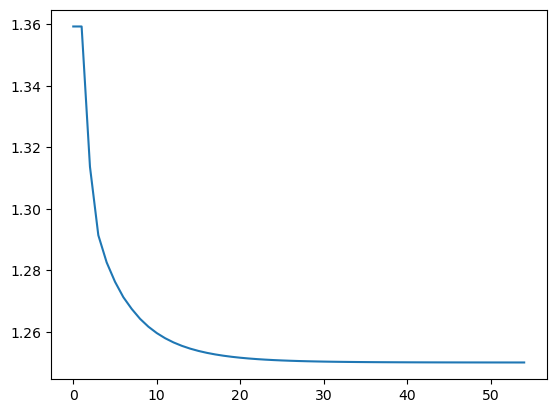

In [175]:
plt.plot(np.array(feasible_objectives)/OPT)

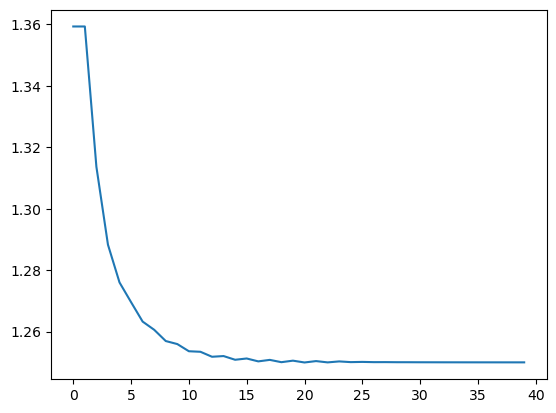

In [172]:
plt.plot(np.array(feasible_objectives)/OPT)

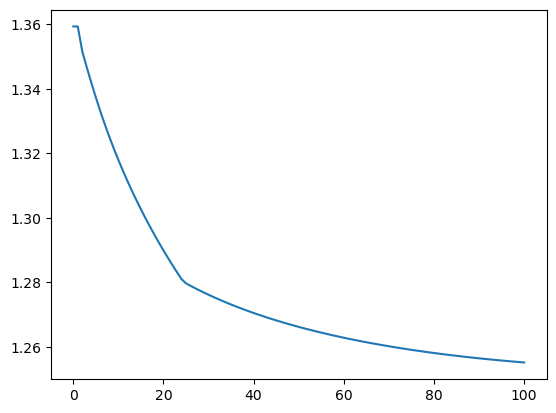

In [165]:
plt.plot(np.array(feasible_objectives)/OPT)

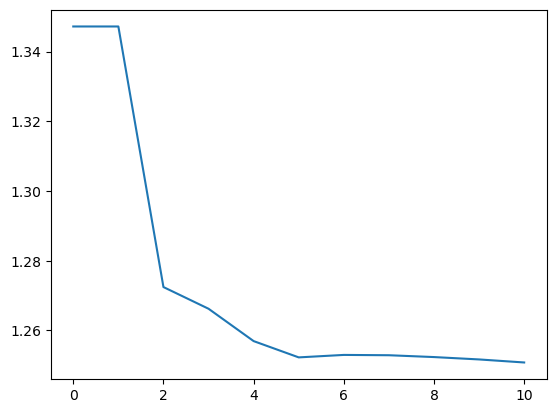

In [126]:
plt.plot(np.array(feasible_objectives)/OPT)

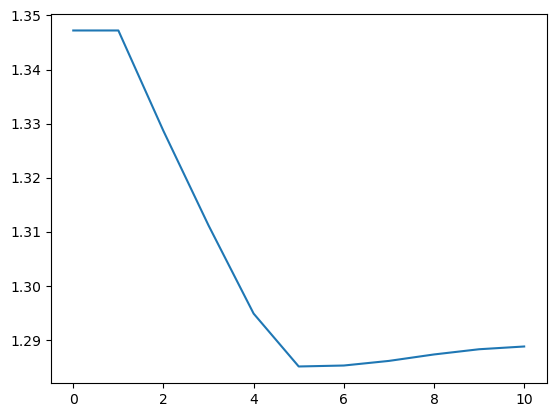

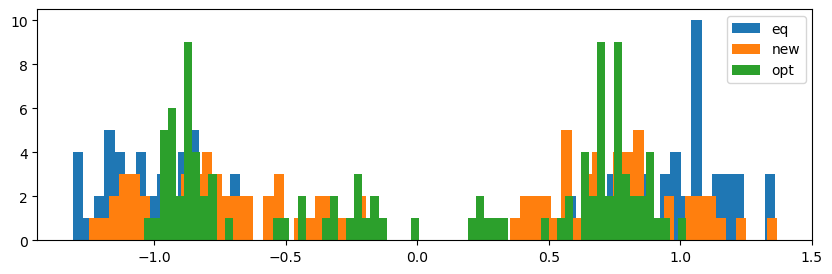

In [31]:
L_sparse = exps[0]["IpL"] -  scipy.sparse.identity(len(s))
IpL_opt = exps[1]["IpL"]
z_eq = np.array(np.linalg.inv((scipy.sparse.identity(len(s))+L_eq/b).todense()) @ s).T.flatten()
z_new = np.array(np.linalg.inv((scipy.sparse.identity(len(s))+L_sparse)) @ s).T.flatten()
z_opt = np.array((np.linalg.inv(IpL_opt) @ s).T.flatten())

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.hist(z_eq.flatten(), label="eq", bins=n//4)
ax.hist(z_new.flatten(), label="new", bins=n//4)
ax.hist(z_opt.flatten(), label="opt", bins=n//4)
#ax[0].set_xlim(-1.5, 1.5)
#ax[1].set_xlim(-1.5, 1.5)
#ax[2].set_xlim(-1.5, 1.5)
#ax[0].set_title("original equilibrium")
#ax[1].set_title("optimized equilibrium")
#ax[2].set_title("optimal equilibrium")
plt.legend()
plt.savefig("Equilibrium distrib.pdf")

In [1051]:
# % change
print((feasible_objectives[0]-feasible_objectives[-1])/feasible_objectives[0])
(feasible_objectives[0]/OPT-feasible_objectives[-1]/OPT)

0.09815638215705065


0.11554126043458557

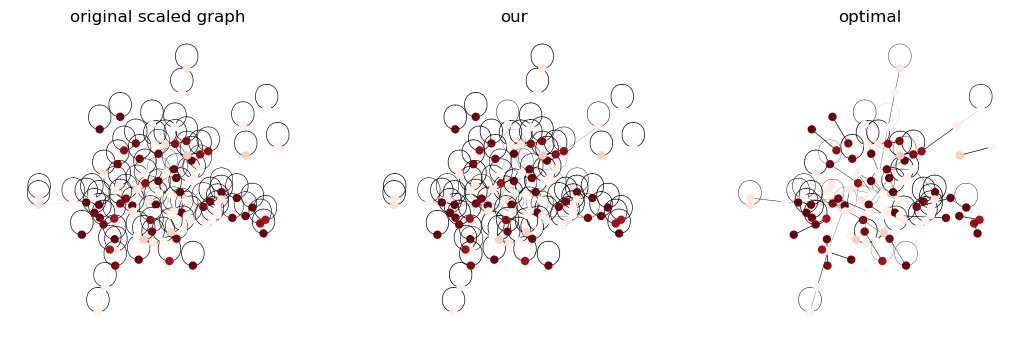

In [1052]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
pos = nx.spring_layout(G_true)


A_eq = np.identity(n) - L_eq.todense()
G_true_scaled = nx.from_numpy_matrix(A_eq)

A = np.identity(n) - L_sparse.todense()
G_new = nx.from_numpy_matrix(A)

A_opt = 2*np.identity(n) - IpL_opt
G_opt = nx.from_numpy_matrix(A_opt)


for i, (graph, title)in enumerate(zip([G_true_scaled, G_new, G_opt],["original scaled graph", "our", "optimal"])):
    weights = [.5*graph[u][v]['weight'] for u,v in graph.edges()]
    nx.draw(graph,  pos=pos, node_color=s.T.flatten(), cmap=plt.cm.Reds, 
            vmin=-1, vmax=1, node_size=25, width=weights, ax=axs[i])
    axs[i].set_title(title)

In [1053]:
A_opt.diagonal().sum()

30.424300241329234

In [1054]:
A.diagonal().sum()

85.16110673206309

---